# Part 1: Clustering and Dimensionality Reduction

## 1a: Preprocessing

In [3]:
import polars as pl
import pandas as pd 

# Load datasets
demo = pd.read_csv("DemoStats.csv")
spend = pd.read_csv("HouseholdSpend.csv")

# Display basic info
print("DemoStats shape:", demo.shape)
print("HouseholdSpend shape:", spend.shape)
print("\nDemoStats preview:\n", demo.head())
print("\nHouseholdSpend preview:\n", spend.head())

# Check for a shared key column
print("\nCommon columns:", set(demo.columns).intersection(set(spend.columns)))

# use a small sample for now
demo = demo.sample(10000, random_state=42)
spend = spend.sample(10000, random_state=42)

DemoStats shape: (868970, 736)
HouseholdSpend shape: (868970, 246)

DemoStats preview:
      CODE     GEO  ECYASQKM  ECYALSQKM  ECYBASPOP  ECYBASHHD  ECYBASHPOP  \
0  A0A0A0  FSALDU         0          0          0          0           0   
1  A0A1A0  FSALDU         0          0         55         33          55   
2  A0A1B0  FSALDU         0          0        588        243         588   
3  A0A1C0  FSALDU         0          0       1793        709        1791   
4  A0A1E0  FSALDU         0          0        452        176         449   

   ECYBAS12P  ECYBAS15P  ECYBAS18P  ...  ECYGEN1GEN  ECYGEN2GEN  ECYGEN3GEN  \
0          0          0          0  ...           0           0           0   
1         55         55         55  ...           0           0          55   
2        561        512        475  ...          11          14         563   
3       1548       1465       1405  ...          50          32        1709   
4        415        389        357  ...          10         

In [4]:
# Merge on common columns
data = pd.merge(demo, spend, on=["CODE", "GEO"], how="inner")

# Drop identifier columns
data = data.drop(columns=["CODE", "GEO"])
data.shape

(10000, 978)

Now let's look into columns with null values and deal with them based on what we find.

In [5]:
# Check for non-numerical columns
non_numerical_cols = len(data.select_dtypes(exclude=['number']).columns)
print(f'Found {non_numerical_cols} non-numerical columns.\n')

# Columns with at least one null
null_columns = data.columns[data.isnull().any()]

# Total number of rows
total_rows = len(data)

# Count nulls and percent nulls
null_counts = data[null_columns].isnull().sum()
null_percent = null_counts / total_rows * 100

# Percent of non-null rows that are zero
zero_percent = (data[null_columns] == 0).sum() / data[null_columns].notnull().sum() * 100

# Combine all into one DataFrame
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Percent Nulls': null_percent,
    'Percent Zeros': zero_percent
})

print(null_summary)

Found 0 non-numerical columns.

           Null Count  Percent Nulls  Percent Zeros
ECYPTAMED        1000          10.00            0.0
ECYPMAMED        1088          10.88            0.0
ECYPFAMED        1496          14.96            0.0
ECYHTAMED        1058          10.58            0.0
ECYHMAMED        1147          11.47            0.0
ECYHFAMED        1565          15.65            0.0
ECYMTNMED        1058          10.58            0.0


There are seven columns with large amounts of null values, but not large enough to simply drop them right away. Let's decide whether to drop them or not based on whether they show any correlation with the target variable.

In [6]:
# Create target variable
temp_df = pd.DataFrame()
temp_df["target"] = data["HSEP001S"] / data["HSHNIAGG"]

# Compare variables with null values
cols_to_compare = data[['ECYPTAMED', 'ECYPMAMED', 'ECYPFAMED',
                        'ECYHTAMED', 'ECYHMAMED', 'ECYHFAMED', 'ECYMTNMED']]

# Calculate correlation with target
correlations = cols_to_compare.corrwith(temp_df['target']).dropna()
correlation_table = correlations.sort_values(key=abs, ascending=False).reset_index()
correlation_table.columns = ['Variable', 'Correlation with Target']

print(correlation_table.to_string(index=False))

 Variable  Correlation with Target
ECYMTNMED                -0.510552
ECYHTAMED                -0.295106
ECYPTAMED                -0.286938
ECYHFAMED                -0.276115
ECYPFAMED                -0.270501
ECYHMAMED                -0.227731
ECYPMAMED                -0.221989


All of the columns with null values seem to have meaningfuly enough correlation with the target such that we should keep them and impute the null values. Let's do that next.

In [7]:
# Creates dict of the column names and the median of the column
dict_median = {column: data[column].median() for column in null_columns}
print(dict_median)

# Replace the NA/NaN values with the median of the column
data.fillna(value=dict_median, inplace=True)

{'ECYPTAMED': 41.3, 'ECYPMAMED': 40.0, 'ECYPFAMED': 42.5, 'ECYHTAMED': 41.1, 'ECYHMAMED': 40.0, 'ECYHFAMED': 42.5, 'ECYMTNMED': 55.0}


Now we will read the metadata files to find any variables related to the target variables, including the target variables themselves and save them for dropping in order to prevent data leakage.

In [8]:
household_meta = pd.read_csv("Documentation/HouseholdSpend 2024 - Metadata.csv")
demostats_meta = pd.read_csv("Documentation/DemoStats 2024 - Metadata.csv")

# Define keywords
keywords = ['insurance', 'pension', 'retirement', 'income tax', 'income']

# Filter by keyword in description
def find_related_vars(df, desc_col='Description', var_col='Variable'):
    # Match keyword in description
    mask = df[desc_col].str.lower().str.contains('|'.join(keywords), na=False)
    related = df[mask].copy()
    related_vars = related[var_col].unique()

    # Include derived variables by prefix match
    derived_mask = df[var_col].apply(lambda x: any(str(x).startswith(prefix) for prefix in related_vars))
    derived = df[derived_mask]

    # Combine and filter columns
    combined = pd.concat([related, derived]).drop_duplicates()
    return combined[['Variable', 'Description', 'Category', 'Root Formula']]

# Find matching variables
demo_related = find_related_vars(demostats_meta)
spend_related = find_related_vars(household_meta)

# Extract variable names for dropping
drop_vars = list(demo_related['Variable'].unique()) + list(spend_related['Variable'].unique())
drop_vars = [str(var).strip() for var in drop_vars]

print("\nDemoStats related variables:\n")
print(demo_related.to_string(index=False))

print("\nHouseholdSpend related variables:\n")
print(spend_related.to_string(index=False))

print("\nTotal variables marked for dropping:", len(drop_vars))
print("Variable names:\n", drop_vars)



DemoStats related variables:

  Variable                                                  Description                                          Category Root Formula
EHYHRI_020        Household Income $0 To $19,999 (Constant Year 2020 $)              Households by Income (Constant Year)  [EHYHRIHHD]
EHYHRI2040   Household Income $20,000 To $39,999 (Constant Year 2020 $)              Households by Income (Constant Year)  [EHYHRIHHD]
EHYHRI4060   Household Income $40,000 To $59,999 (Constant Year 2020 $)              Households by Income (Constant Year)  [EHYHRIHHD]
EHYHRI6080   Household Income $60,000 To $79,999 (Constant Year 2020 $)              Households by Income (Constant Year)  [EHYHRIHHD]
EHYHRIX100   Household Income $80,000 To $99,999 (Constant Year 2020 $)              Households by Income (Constant Year)  [EHYHRIHHD]
EHYHRI100P     Household Income $100,000 Or Over (Constant Year 2020 $)              Households by Income (Constant Year)  [EHYHRIHHD]
EHYHRIX125 Household Inc

We've found 176 variables that are related to the target variables, many of which are demographic statistics that would allow the target variables to be reverse engineered, at least to some degree. So let's drop these variables, but note that the actual provied data does not actually include all these variables since the metadata file and the actual data are out of sync, as explained by TAs already. Let's just note the ones that we didn't find in the data and then remove the ones that we did find!

In [9]:
found = [col for col in drop_vars if col in data.columns]
missing = [col for col in drop_vars if col not in data.columns]

print(f"\nFound {len(found)} of {len(drop_vars)} drop_vars in the data.")
print("Examples not found:", missing[:10])

before_cols = data.shape[1]
# Drop columns
data = data.drop(columns=[col for col in drop_vars if col in data.columns])
after_cols = data.shape[1]

print(f"\nDropped {before_cols - after_cols} columns from data.")


Found 47 of 176 drop_vars in the data.
Examples not found: ['EHYHRI_020', 'EHYHRI2040', 'EHYHRI4060', 'EHYHRI6080', 'EHYHRIX100', 'EHYHRI100P', 'EHYHRIX125', 'EHYHRIX150', 'EHYHRIX200', 'EHYHRI200P']

Dropped 47 columns from data.


Finally, we want to check for outliers in the columns, for each outlier we find outside the IQR range, we will set it to the lower and upper bound of the IQR respectively. We chose IQR here because the z-score clipping method is sensitive to datasets that are very skewed and since we don't know all the details about how skewed and strong the outliers in this dataset are, it's better to be conservative and just use the robust IQR method.

In [10]:
# IQR-based winsorization
for col in data.select_dtypes(include='number').columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower, upper=upper)

print("Outliers have been capped using IQR method (1.5 * IQR).")

Outliers have been capped using IQR method (1.5 * IQR).


Finally, we will remove columns with very low variance (essentially repeated data and noise), and then scale the data.

In [11]:
from sklearn.preprocessing import StandardScaler

# Drop columns with all same values (including all zeros)
low_variance_cols = data.columns[data.nunique() <= 1]
data = data.drop(columns=low_variance_cols)
print(f"Dropped {len(low_variance_cols)} low-variance columns.")

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)

# Output shape of cleaned and scaled data
print("Final cleaned shape:", data_scaled_df.shape)

Dropped 304 low-variance columns.
Final cleaned shape: (10000, 627)


## 1b K-Means Clustering

Since the dataset is so large, and our machines are not so powerful in comparison, we can use the elbow and silhouette methods on a sample of the data to get an idea of what the number of clusters should be. Based on that we can run one (or just much fewer) KMeans on the full dataset.

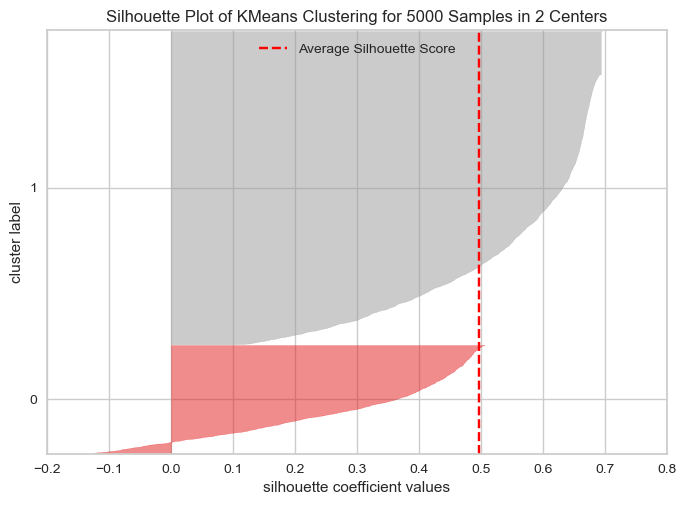

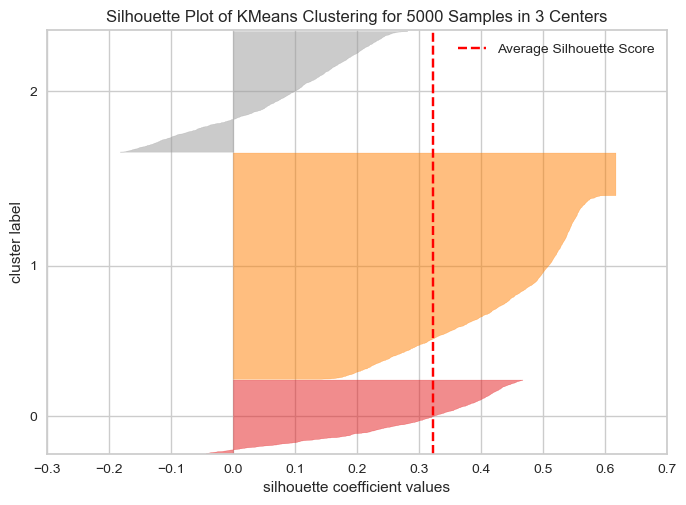

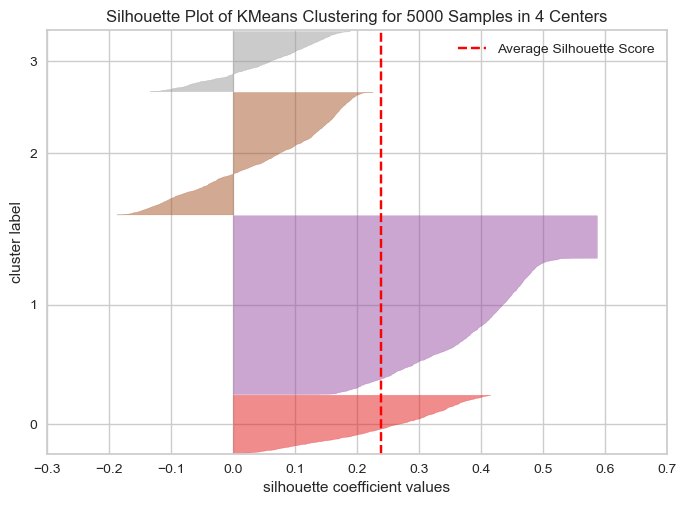

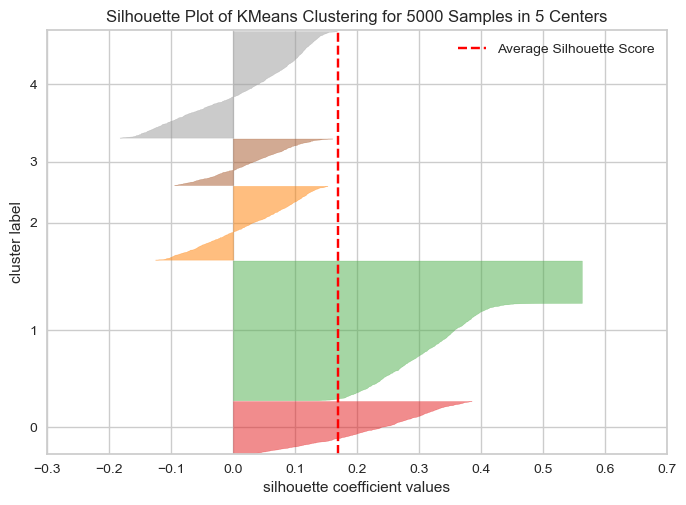

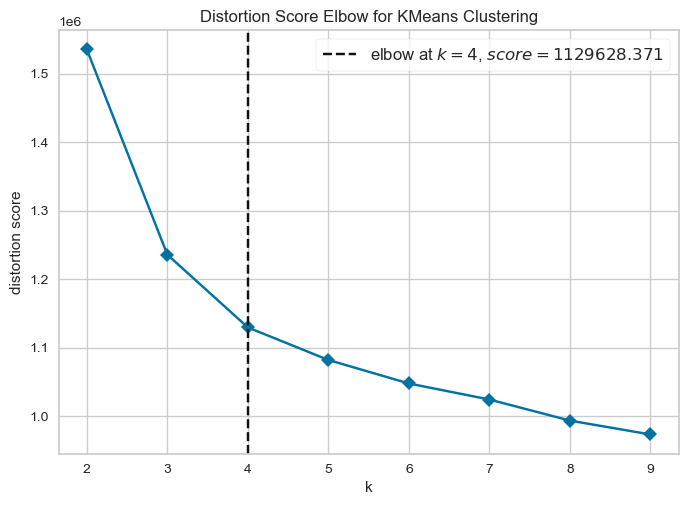

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

# === STEP 1: Sample the data ===
sample_size = 20000

sample_size = 5000

rng = np.random.default_rng(seed=42)
sample_idx = rng.choice(data_scaled.shape[0], size=sample_size, replace=False)
sample = data_scaled[sample_idx]

# === STEP 2: Try different cluster counts ===

# === STEP 3: Plot elbow and silhouette ===
for i in range(2, 6):
    visualizer = SilhouetteVisualizer(KMeans(n_clusters=i, random_state=42))
    visualizer.fit(sample)
    visualizer.show()


visualizer = KElbowVisualizer(KMeans(random_state=42), k=(2, 10), locate_elbow=True, timings=False)
visualizer.fit(sample)
visualizer.show()



TODO: Discuss difference

In [34]:

# Fit KMeans for k = 3 and k = 4 on full standardized data
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels_3 = kmeans_3.fit_predict(data_scaled)

kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init='auto')
labels_4 = kmeans_4.fit_predict(data_scaled)

# Optionally: add these labels to a DataFrame for inspection later
clustered_df = pd.DataFrame(data_scaled, columns=[f"var_{i}" for i in range(data_scaled.shape[1])])
clustered_df["cluster_3"] = labels_3
clustered_df["cluster_4"] = labels_4

## 1c Dimensionality Reduction

In [49]:
from sklearn.decomposition import PCA

# Run PCA on full standardized data
pca = PCA(random_state=42, n_components=3)
pca_data = pca.fit_transform(data_scaled)

# Explained variance for each component
print("Explained variance ratio (PC1–PC3):", pca.explained_variance_ratio_[:3])

Explained variance ratio (PC1–PC3): [0.67381571 0.03748504 0.03017035]


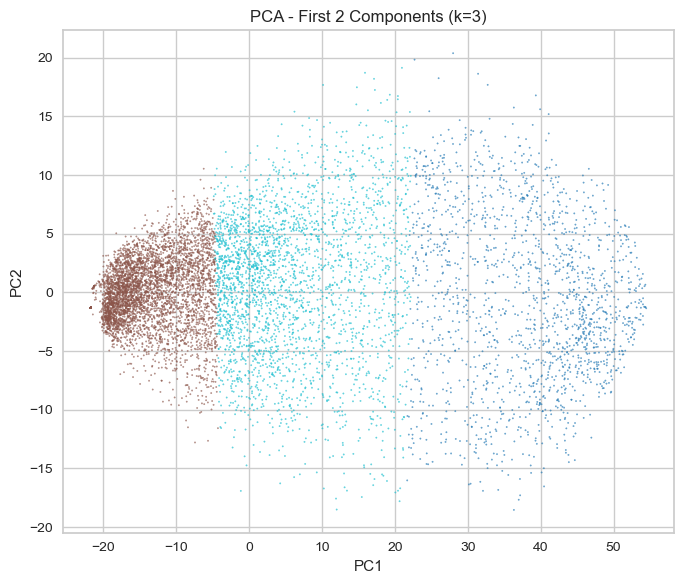

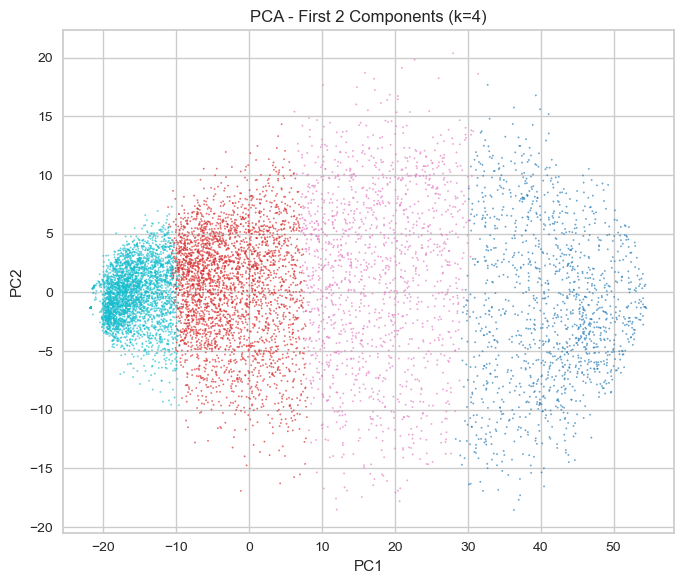

In [50]:
def plot_clusters(pca_data, labels, k):
    plt.figure(figsize=(7, 6))
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='tab10', s=1, alpha=0.6)
    plt.title(f"PCA - First 2 Components (k={k})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for k=3 and k=4
plot_clusters(pca_data, labels_3, k=3)
plot_clusters(pca_data, labels_4, k=4)

In [51]:
# Create DataFrame with PCA results and cluster labels
pca_df = pd.DataFrame(pca_data, columns=["PC1", "PC2", "PC3"])
pca_df["cluster_3"] = labels_3
pca_df["cluster_4"] = labels_4

# Mean values for each component per cluster
mean_pcs_k3 = pca_df.groupby("cluster_3")[["PC1", "PC2", "PC3"]].mean()
mean_pcs_k4 = pca_df.groupby("cluster_4")[["PC1", "PC2", "PC3"]].mean()

print("\nMean PC values per cluster (k=3):")
print(mean_pcs_k3)

print("\nMean PC values per cluster (k=4):")
print(mean_pcs_k4)


Mean PC values per cluster (k=3):
                 PC1       PC2       PC3
cluster_3                               
0          38.067461 -0.579422 -0.144761
1         -14.899364 -0.199135  0.033915
2           5.906965  0.737743  0.021733

Mean PC values per cluster (k=4):
                 PC1       PC2       PC3
cluster_4                               
0          41.483700 -1.305008 -0.392749
1          -2.558301  0.395562  0.675838
2          17.269722  1.589534 -0.022894
3         -17.146761 -0.407426 -0.348810


In [52]:
# Create a DataFrame for PCA loadings
pca_loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2", "PC3"],
    index=data.columns  # original variable names
)

# Show top absolute contributors to PC1
top_pc1 = pca_loadings["PC1"].abs().sort_values(ascending=False).head(20)
print("Top contributing variables to PC1:")
print(pca_loadings.loc[top_pc1.index].sort_values("PC1", ascending=False))

# Show top absolute contributors to PC2
top_pc2 = pca_loadings["PC2"].abs().sort_values(ascending=False).head(20)
print("Top contributing variables to PC2:")
print(pca_loadings.loc[top_pc2.index].sort_values("PC2", ascending=False))

Top contributing variables to PC1:
                 PC1       PC2       PC3
ECYHOMSING  0.048065 -0.014070  0.012932
ECYMOTSING  0.048062 -0.014841  0.012645
ECYMOBHPOP  0.048058 -0.017215  0.011264
ECYHTAHPOP  0.048054 -0.017651  0.011162
ECYVISHPOP  0.048054 -0.017651  0.011162
ECYMOTHPOP  0.048054 -0.017651  0.011162
ECYHSZTPER  0.048054 -0.017651  0.011162
ECYTIMHPOP  0.048054 -0.017651  0.011162
ECYRIMHPOP  0.048054 -0.017651  0.011162
ECYPIMHPOP  0.048054 -0.017651  0.011162
ECYRELHPOP  0.048054 -0.017651  0.011162
ECYGENHPOP  0.048054 -0.017651  0.011162
ECYTCAHPOP  0.048054 -0.017651  0.011162
ECYAIDHPOP  0.048054 -0.017651  0.011162
ECYKNOHPOP  0.048054 -0.017651  0.011162
ECYHOMHPOP  0.048054 -0.017651  0.011162
ECYAIMHPOP  0.048054 -0.017651  0.011162
ECYBASHPOP  0.048054 -0.017651  0.011162
ECYBAS12HP  0.048029 -0.016215  0.013121
ECYMARHP15  0.048007 -0.016617  0.014242
Top contributing variables to PC2:
                 PC1       PC2       PC3
HSSH037A    0.017743  0.1135

## 1b UMAP

In [74]:
import umap

reducer = umap.UMAP(n_neighbors=40,
                    n_components=2,
                    metric='euclidean',
                    random_state=42,
                    min_dist=1,
                    spread=1.5,
                    low_memory=False,
                    n_epochs=1000,
                    verbose=True,
                    n_jobs=-1)

UMAP_embedding = reducer.fit_transform(data_scaled)

/Users/sepehr/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sepehr/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(low_memory=False, min_dist=1, n_epochs=1000, n_jobs=1, n_neighbors=40, random_state=42, spread=1.5, verbose=True)
Fri Apr 18 06:14:21 2025 Construct fuzzy simplicial set
Fri Apr 18 06:14:21 2025 Finding Nearest Neighbors
Fri Apr 18 06:14:21 2025 Building RP forest with 10 trees
Fri Apr 18 06:14:21 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Fri Apr 18 06:14:25 2025 Finished Nearest Neighbor Search
Fri Apr 18 06:14:25 2025 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Fri Apr 18 06:15:02 2025 Finished embedding


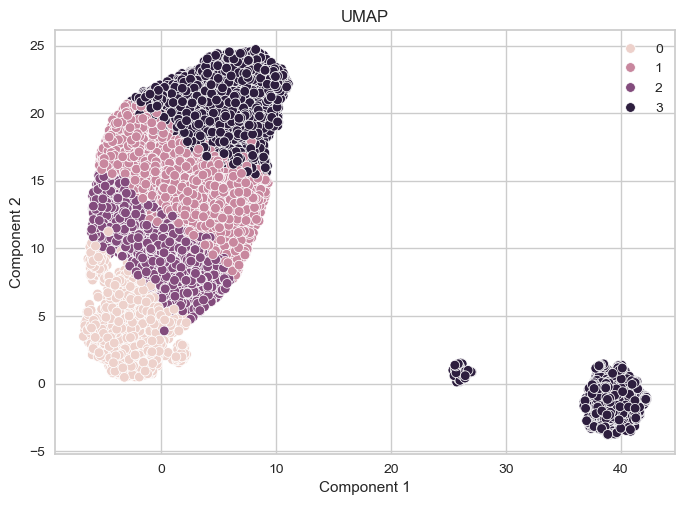

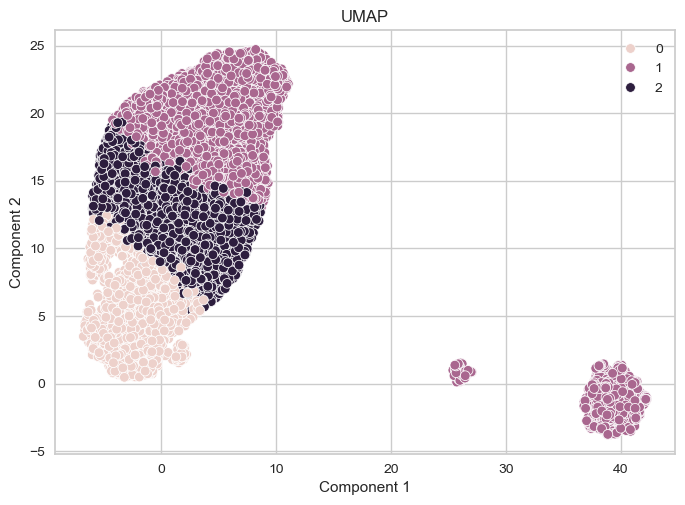

In [76]:
import seaborn as sns

sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=labels_4)
plt.title("UMAP")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=labels_3)
plt.title("UMAP")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


AttributeError: module 'pyarrow.lib' has no attribute 'ListViewType'